In [1]:
import sys
sys.path.insert(0, "../")

import simul.cna.api as cna
import simul.patients.api as patut
import simul.run.api as run

Global seed set to 0


In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import scvi

In [3]:
SELECTED_PATIENTS = ['C123', 'C130', 'C137', 'C143', 'C144']

In [4]:
DATAPATH = pathlib.Path("/cluster/work/boeva/scRNAdata/preprocessed/crc/2022-06-14_14-54-09/data")

adata = sc.read_h5ad(DATAPATH / "non_malignant.h5ad")

adata = adata[adata.obs.celltype.isin(["TCD4","TCD8","Tgd","Macro"])].copy()
adata = adata[adata.obs.SINGLECELL_TYPE=="SC3Pv2"].copy()


In [5]:
scvi.model.SCVI.setup_anndata(adata, batch_key="sample_id")
model = scvi.model.SCVI.load("/cluster/home/jyates/Documents/home_dir/CanSig-Supplementary-Information/simulations/scvi-model/model_crc.pt/", adata)

INFO     File /cluster/home/jyates/Documents/home_dir/CanSig-Supplementary-Information/simula
         tions/scvi-model/model_crc.pt/model.pt already downloaded                           


2022-08-16 14:31:31.529018: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-16 14:31:31.529108: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


In [6]:
genome = cna.Genome(genes_df=adata.var, chromosome_column="chromosome", start_column="start")

In [7]:
anchors = ["CD4","CD8A","HOPX"]

In [8]:
genome.get_gene_chromosome("HOPX")

'chr4'

In [9]:
CNVGenerator = cna.CNVPerBatchGenerator(
        genome=genome,
        anchors = anchors,
        chromosomes_gain=["chr1","chr2","chr4","chr14","chr19","chr20"],
        chromosomes_loss=["chr3","chr5","chr13","chr15"],
        dropout=0.3,
        dropout_child=0.3,
        p_anchor = 0.3,
        min_region_length=200,
        max_region_length=300,
        seed = np.random.randint(100),
)

In [10]:
CNVGenerator.anchors

['CD4', 'CD8A', 'HOPX']

In [23]:
dataset = patut.Dataset(n_batches=10,n_programs=3,CNVGenerator=CNVGenerator,seed=np.random.randint(100),n_malignant_max=400,n_malignant_min=200,n_healthy_max=250,n_healthy_min=100)

In [24]:
for pat in dataset.patients:
    print(pat.batch, pat.n_total_cells(), pat.subclone_proportions)

patient1 404 [0.48402197 0.51597803]
patient2 552 [0.00627999 0.00110177 0.05701207 0.46547939 0.47012678]
patient3 595 [9.41302379e-02 6.01884790e-01 3.03571043e-01 4.13928906e-04]
patient4 465 [0.06005173 0.93994827]
patient5 333 [0.57352107 0.07222605 0.35425288]
patient6 550 [0.30047138 0.29570548 0.40382314]
patient7 466 [0.01441418 0.26878535 0.28096033 0.43584014]
patient8 500 [0.02247273 0.25520893 0.72231835]
patient9 447 [0.00942008 0.15668702 0.8338929 ]
patient10 514 [0.84668825 0.15331175]


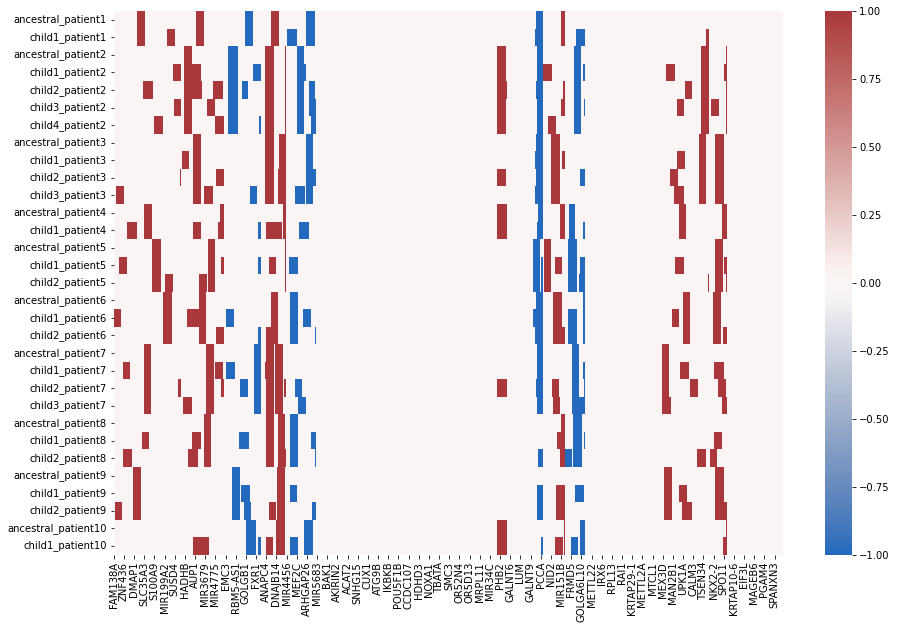

In [25]:
run.plot_subclone_profile(dataset=dataset,filename="heatmap_subclones_replacement.png")

In [26]:
anchor_alphas = run.generate_anchor_alphas(anchors=anchors)

In [27]:
anchor_alphas

{(False, False, False): [1, 1, 1],
 (False, False, True): [1, 1, 20],
 (False, True, False): [1, 20, 1],
 (False, True, True): [1, 20, 20],
 (True, False, False): [20, 1, 1],
 (True, False, True): [20, 1, 20],
 (True, True, False): [20, 20, 1],
 (True, True, True): [20, 20, 20]}

In [28]:
MIN_PROGRAMS = 2
DROPOUT = 0

In [29]:
distribution = cna.generate_probabilities(
    anchors_to_alphas=anchor_alphas,
    batches=dataset.batches,
    min_programs=MIN_PROGRAMS,
    prob_dropout=DROPOUT,
    program_names=dataset.programs,
    seed=7,
)

In [30]:
distribution._conditional_probability

{((False, False, False),
  'patient1'): array([0.19956611, 0.04604679, 0.7543871 ]),
 ((False, False, True),
  'patient1'): array([4.78527062e-04, 1.37824198e-01, 8.61697275e-01]),
 ((False, True, False),
  'patient1'): array([0.02362314, 0.92950476, 0.0468721 ]),
 ((False, True, True),
  'patient1'): array([0.04433048, 0.53909652, 0.416573  ]),
 ((True, False, False),
  'patient1'): array([0.92161384, 0.02216639, 0.05621977]),
 ((True, False, True),
  'patient1'): array([0.64089739, 0.03753076, 0.32157185]),
 ((True, True, False),
  'patient1'): array([0.58757805, 0.41175231, 0.00066964]),
 ((True, True, True), 'patient1'): array([0.2609996 , 0.41317487, 0.32582553]),
 ((False, False, False),
  'patient2'): array([0.20213524, 0.5462649 , 0.25159986]),
 ((False, False, True),
  'patient2'): array([0.08588345, 0.00554984, 0.90856671]),
 ((False, True, False),
  'patient2'): array([0.03648608, 0.95131675, 0.01219717]),
 ((False, True, True),
  'patient2'): array([0.02308557, 0.48287205, 

In [31]:
all_malignant_obs = run.simulate_malignant_comp_batches(dataset=dataset, prob_dist=distribution)

In [32]:
all_healthy_obs = run.simulate_healthy_comp_batches(dataset=dataset)

In [34]:
sample_patients = run.sample_patient_original_replacement(dataset=dataset, selected_patients=SELECTED_PATIENTS)

In [35]:
all_malignant_gex = run.simulate_gex_malignant(adata=adata, model=model, dataset=dataset, 
                                               all_malignant_obs=all_malignant_obs, 
                                               sample_patients=sample_patients)

Getting patient parameters
Getting cell specific parameters
Starting ZINB sampling
Getting patient parameters
Getting cell specific parameters
Starting ZINB sampling
Getting patient parameters
Getting cell specific parameters
Starting ZINB sampling
Getting patient parameters
Getting cell specific parameters
Starting ZINB sampling
Getting patient parameters
Getting cell specific parameters
Starting ZINB sampling
Getting patient parameters
Getting cell specific parameters
Starting ZINB sampling
Getting patient parameters
Getting cell specific parameters
Starting ZINB sampling
Getting patient parameters
Getting cell specific parameters
Starting ZINB sampling
Getting patient parameters
Getting cell specific parameters
Starting ZINB sampling
Getting patient parameters
Getting cell specific parameters
Starting ZINB sampling


In [36]:
all_healthy_gex = run.simulate_gex_healthy(adata=adata, model=model, 
                                               all_healthy_obs=all_healthy_obs, 
                                               sample_patients=sample_patients)

Getting patient parameters
Getting cell specific parameters
Starting ZINB sampling
Getting patient parameters
Getting cell specific parameters
Starting ZINB sampling
Getting patient parameters
Getting cell specific parameters
Starting ZINB sampling
Getting patient parameters
Getting cell specific parameters
Starting ZINB sampling
Getting patient parameters
Getting cell specific parameters
Starting ZINB sampling
Getting patient parameters
Getting cell specific parameters
Starting ZINB sampling
Getting patient parameters
Getting cell specific parameters
Starting ZINB sampling
Getting patient parameters
Getting cell specific parameters
Starting ZINB sampling
Getting patient parameters
Getting cell specific parameters
Starting ZINB sampling
Getting patient parameters
Getting cell specific parameters
Starting ZINB sampling


In [37]:
import scipy
import anndata as ad
def save_batch_gex(batch_name,batch_gex,gene_names,df_obs,savedir):
    
    batch_gex = scipy.sparse.csr_matrix(batch_gex)
    batch_gex = pd.DataFrame.sparse.from_spmatrix(batch_gex, index=df_obs.index, columns=gene_names)
    adata = ad.AnnData(batch_gex, obs=df_obs)
    adata.write(savedir / f"{batch_name}.h5ad")

In [39]:
savedir = pathlib.Path("/cluster/work/boeva/scRNAdata/cna_simulation/raw_datasets/crc_5_replacement/")
gene_names = list(adata.var_names)

for pat in all_malignant_gex:
    
    df_mal = all_malignant_obs[pat]
    df_h = all_healthy_obs[pat]
    df_obs = pd.concat([df_mal,df_h])
    
    gex_mal = all_malignant_gex[pat]
    gex_h = all_healthy_gex[pat]
    batch_gex = np.concatenate([gex_mal,gex_h])
    
    print(f"Saving {pat}")
    save_batch_gex(batch_name=pat,
                   batch_gex=batch_gex,
                   gene_names=gene_names,
                   df_obs=df_obs,
                   savedir=savedir)

Saving patient1


/tmp/ipykernel_3525765/1234963146.py:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(batch_gex, obs=df_obs)


Saving patient2


/tmp/ipykernel_3525765/1234963146.py:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(batch_gex, obs=df_obs)


Saving patient3


/tmp/ipykernel_3525765/1234963146.py:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(batch_gex, obs=df_obs)


Saving patient4


/tmp/ipykernel_3525765/1234963146.py:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(batch_gex, obs=df_obs)


Saving patient5


/tmp/ipykernel_3525765/1234963146.py:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(batch_gex, obs=df_obs)


Saving patient6


/tmp/ipykernel_3525765/1234963146.py:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(batch_gex, obs=df_obs)


Saving patient7


/tmp/ipykernel_3525765/1234963146.py:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(batch_gex, obs=df_obs)


Saving patient8


/tmp/ipykernel_3525765/1234963146.py:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(batch_gex, obs=df_obs)


Saving patient9


/tmp/ipykernel_3525765/1234963146.py:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(batch_gex, obs=df_obs)


Saving patient10


/tmp/ipykernel_3525765/1234963146.py:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(batch_gex, obs=df_obs)


In [44]:
adatas = [sc.read_h5ad(savedir / f"patient{i}.h5ad") for i in range(1,11)]

In [45]:
simadata = adatas[0].concatenate(*adatas[1:])

/cluster/home/jyates/Documents/home_dir/scrna/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [42]:
import infercnvpy as cnv

In [46]:
sc.pp.normalize_total(simadata, target_sum=10000)
sc.pp.log1p(simadata)
sc.pp.neighbors(simadata)
sc.tl.umap(simadata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [47]:
sc.pp.neighbors(simadata, use_rep="X_pca")
sc.tl.umap(simadata)

In [48]:
simadata.obs["pat_subclone"] = simadata.obs.subclone.astype(str) + "_" + simadata.obs.batch.astype(str)
simadata.obs["pat_subclone"] = simadata.obs["pat_subclone"].apply(lambda x: "NA" if "NA" in x else x)

In [49]:
simadata.var['mt'] = simadata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(simadata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

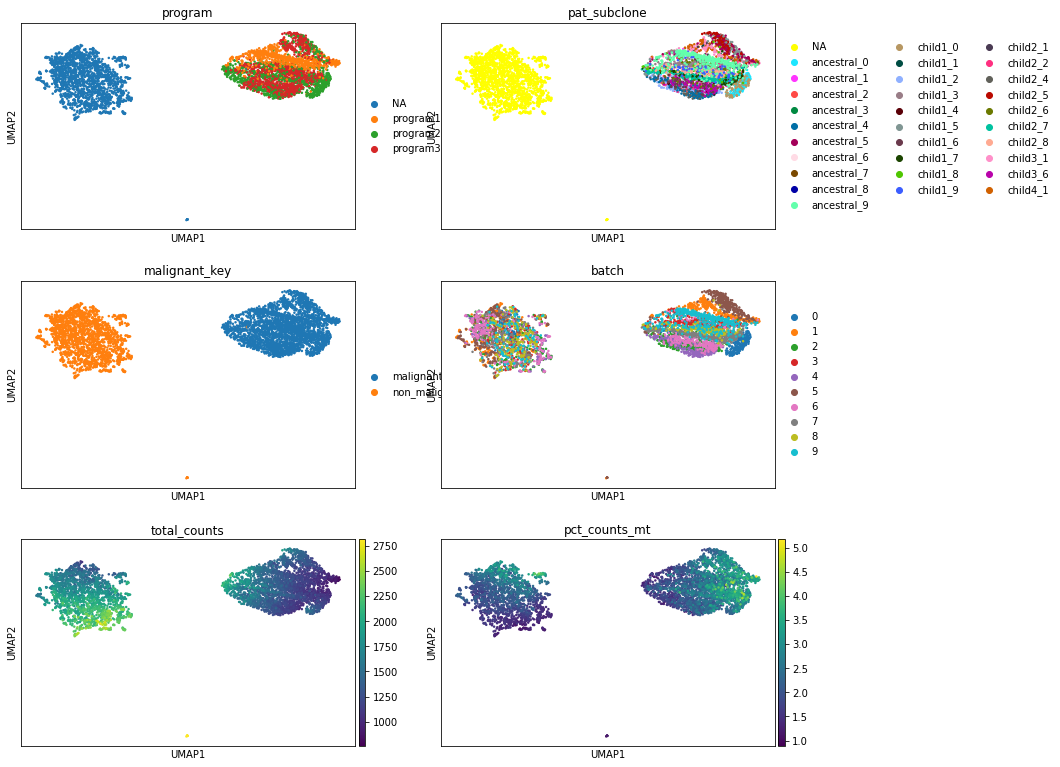

In [50]:
sc.pl.umap(simadata,color=["program","pat_subclone","malignant_key", "batch", "total_counts", "pct_counts_mt"],ncols=2, save="full_dataset_red_wrepl.png")

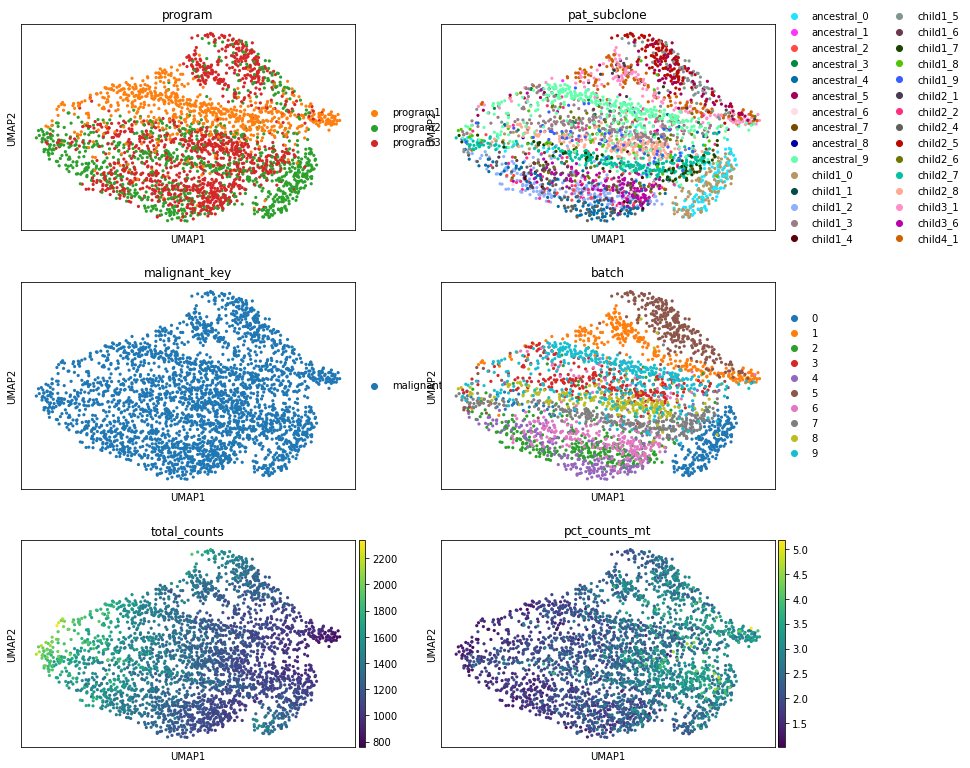

In [56]:
sc.pl.umap(simadata[simadata.obs.malignant_key=="malignant"].copy(),color=["program","pat_subclone","malignant_key", "batch", "total_counts", "pct_counts_mt"],ncols=2)